# Caso Práctico Final: Predicción de Fraude

El conjunto de datos para este caso práctico trata sobre fraude de cuentas bancarias (BAF) y se publicó en NeurIPS 2022. Comprende un total de 6 conjuntos de datos tabulares sintéticos diferentes sobre fraude de cuentas bancarias. 

El enlace a la publicación puedes encontrarlo aquí:
[Enlace publicación](https://arxiv.org/pdf/2211.13358.pdf)

Y la descripción del conjunto de datos se puede encontrar en el siguiente enlace de [Kaggle](https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022) donde se detalla las columnas que los componen. Utiliza el conjunto de datos que se te proporciona junto con este enunciado ya que ha sido modificado ligeramente para este caso práctico.
De los 6 conjuntos de datos trabajaremos con *Base.csv* que proporciona una muestra representativa del conjunto de datos original.

El objetivo final de este proyecto es identificar si una solicitud de apertura de cuenta bancaria es fraudulenta o no. Esto se logrará mediante la implementación de un modelo de clasificación binaria que prediga si una solicitud de apertura de cuenta bancaria es fraudulenta, variable fraud_bool. En la asignatura de Machine Learning aprenderemos cómo entrenar y evaluar modelos de clasificación, en esta asignatura nos centraremos en la limpieza y preparación de los datos, así como el análisis exploratorio de los mismos.

## Lectura de Datos

In [116]:
import pandas as pd

In [ ]:
df = pd.read_csv("data/base.csv")
# df = pd.read_csv("data/base.csv").sample(frac=.1) # para utilizar una muestra

*Filas y columnas*

Comprueba el número de filas y columnas del *df*

In [118]:
print("Número de filas y columnas:")
print(df.shape)

Número de filas y columnas:
(1000000, 32)


*Balanceo de clases*

Comprueba el ratio de 1s y 0s de la variable *fraud_bool*

In [119]:
print("\nPorcentaje de cada clase:")
print(df['fraud_bool'].value_counts(normalize=True))


Porcentaje de cada clase:
fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64


##  1. Tratamiento de Nulos y Duplicados

Identifica si el conjunto de datos tiene valores nulos o duplicados y toma una decisión de cómo tratarlos.

### Respuesta:

En esta sección analizamos si el conjunto de datos contenía valores nulos o duplicados.

- No se encontraron filas duplicadas.
- Algunas variables presentaban valores nulos.
- Se decidió eliminar las filas con valores nulos únicamente en las variables más relevantes para el análisis, conservando la mayor cantidad de datos posible.

Después del tratamiento, solo quedaron 2.015 filas con valores nulos, que también fueron eliminadas para facilitar el análisis multivariante y el PCA.


### 1.1. Valores nulos

In [120]:
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
fraud_bool                               0
income                                   0
name_email_similarity                    0
prev_address_months_count           712920
current_address_months_count          4254
customer_age                             0
days_since_request                       0
intended_balcon_amount                   0
payment_type                             0
zip_count_4w                             0
velocity_6h                              0
velocity_24h                             0
velocity_4w                              0
bank_branch_count_8w                     0
date_of_birth_distinct_emails_4w         0
employment_status                        0
credit_risk_score                   166771
email_is_free                         3038
housing_status                           0
phone_home_valid                         0
phone_mobile_valid                       0
bank_months_count                   253635
has_other_cards            

In [ ]:
# Eliminar columna con muchos nulos
df = df.drop(columns=['prev_address_months_count'])

# Rellenar nulos con la mediana
df['credit_risk_score'] = df['credit_risk_score'].fillna(df['credit_risk_score'].median())
df['bank_months_count'] = df['bank_months_count'].fillna(df['bank_months_count'].median())
df['current_address_months_count'] = df['current_address_months_count'].fillna(df['current_address_months_count'].median())

# Rellenar con la moda
df['email_is_free'] = df['email_is_free'].fillna(df['email_is_free'].mode()[0])

# Verificar que ya no haya nulos
print("¿Aún hay valores nulos?")
print(df.isnull().sum().sum())

¿Aún hay valores nulos?
2015


In [122]:
# Eliminar filas que aún tienen valores nulos
df = df.dropna()

# Verificar nuevamente
print("¿Aún hay valores nulos?")
print(df.isnull().sum().sum())

¿Aún hay valores nulos?
0


### 1.2. Duplicados

In [123]:
print("\nNúmero de filas duplicadas:")
print(df.duplicated().sum())


Número de filas duplicadas:
0


No hacer nada.

## 2. Análisis Univariante

Estudia de forma independiente cada una de las variables del dataset, utiliza los métodos gráficos y numéricos adecuados según el tipo de variable. Toma las decisiones que consideres oportunas en base a los análisis realizados, esto puede ser descartar variables, tratar outliers, agrupar categorías… 

### Respuesta:

Se utilizó la función `select_dtypes` de pandas para separar las columnas en dos listas:

- Variables categóricas
- Variables numéricas

Este paso fue necesario para preparar los análisis gráficos y numéricos posteriores en la etapa de análisis multivariante.


### 2.1. Categóricas y Binarias

In [124]:
# Obtener lista de columnas categóricas
columnas_categoricas = df.select_dtypes(include=['object', 'bool']).columns.tolist()
print("\nColumnas categóricas:")
print(columnas_categoricas)


Columnas categóricas:
['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


### 2.2. Numéricas

In [125]:
# Obtener lista de columnas categóricas
columnas_numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Columnas numéricas:")
print(columnas_numericas)

Columnas numéricas:
['fraud_bool', 'income', 'name_email_similarity', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']


## 3. Análisis Multivariante

Estudia cada una de las variables en relación con la variable objetivo y quédate únicamente con aquellas relevantes. Además, elimina variables que estén altamente correladas entre sí.

### Respuesta:

En esta etapa se estudó la relación entre cada variable y la variable objetivo (`fraud_bool`) para identificar cuáles eran relevantes para la detección de fraude.

Los pasos realizados fueron:

Se calculó y visualizó la matriz de correlación entre todas las variables numéricas mediante un heatmap. No se observaron variables con correlación superior a 0.9, lo que indica que no fue necesario eliminar variables por redundancia. Algunas variables mostraban correlaciones medias (entre 0.4 y 0.6), como `velocity_6h` con `velocity_24h`, o `velocity_24h` con `velocity_4w`, pero se decidió conservarlas porque cada una aportaba una variación distinta en la relación con el fraude.

Se usaron gráficos de boxplot para comparar la distribución de cada variable numérica según si el caso era fraude o no. Se conservaron variables cuya mediana o distribución era visiblemente diferente entre las clases y se descartaron variables cuando era casi idéntica.

Se crearon gráficos de barras para visualizar el promedio de fraude por categoría en cada variable categórica. Se conservaron variables con distribuciones desbalanceadas de fraude por categoría.

Con base en los resultados visuales, se seleccionaron las variables más informativas y se descartaron aquellas que:
- Eran constantes o casi constantes
- No mostraban diferencias significativas con respecto a `fraud_bool`
- Estaban muy correlacionadas con otras más representativas

Finalmente, se creó un nuevo DataFrame `.csv` para su uso en el PCA.


### 3.1. Correlaciones

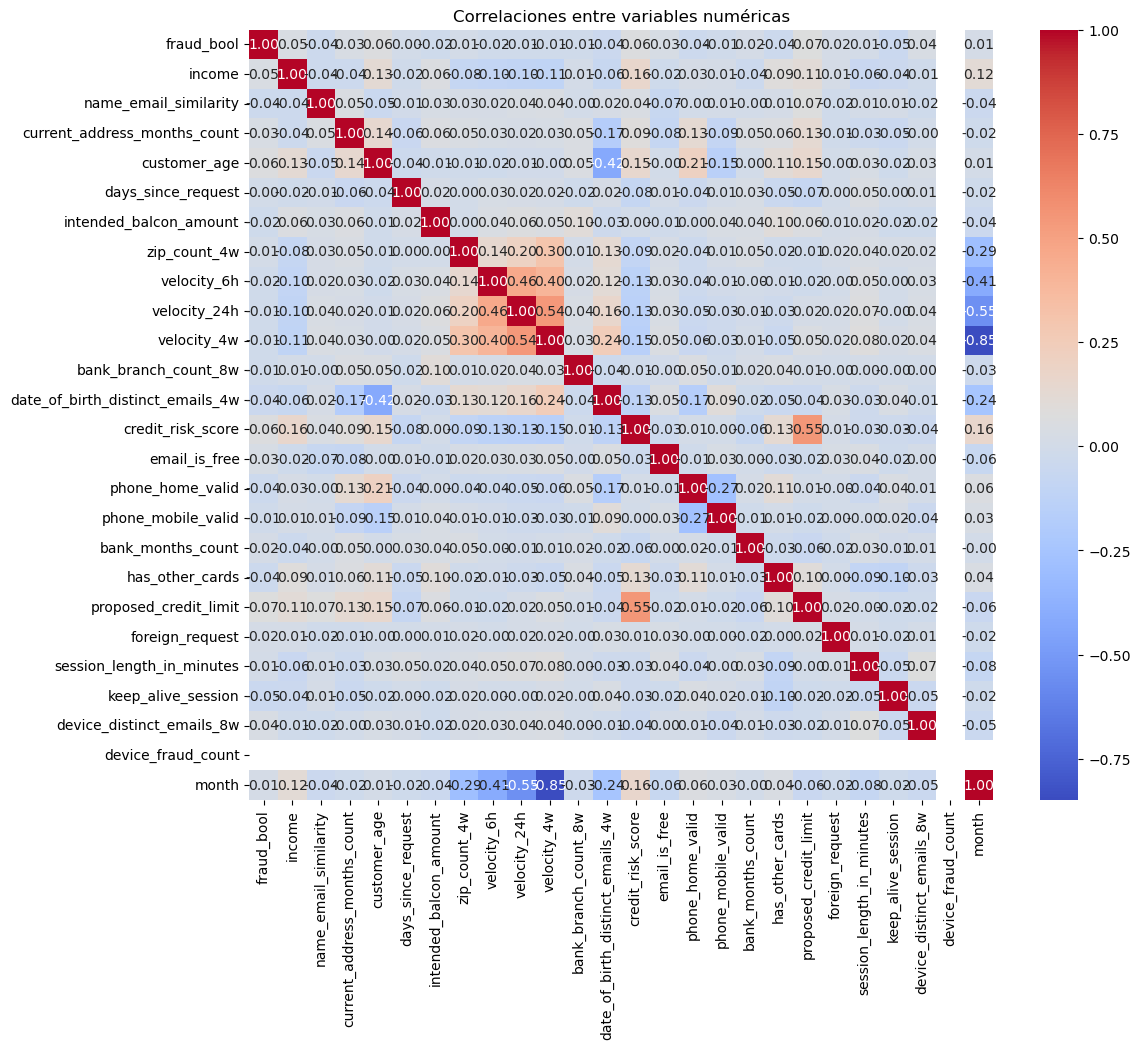

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlaciones = df[columnas_numericas].corr()

# Mostrar un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlaciones entre variables numéricas")
plt.show()

### 3.2. Numéricas vs Target

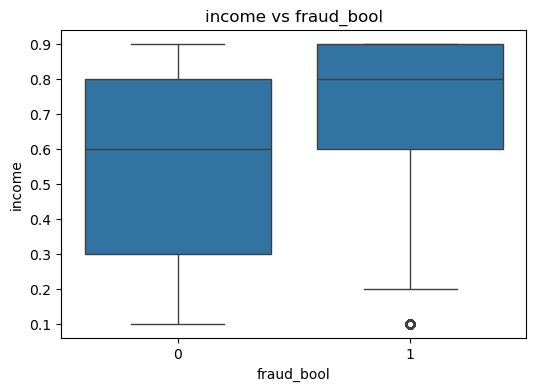

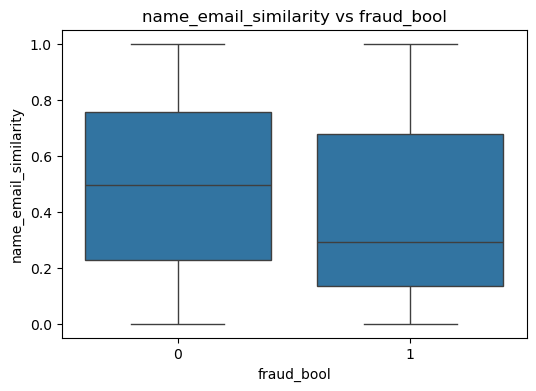

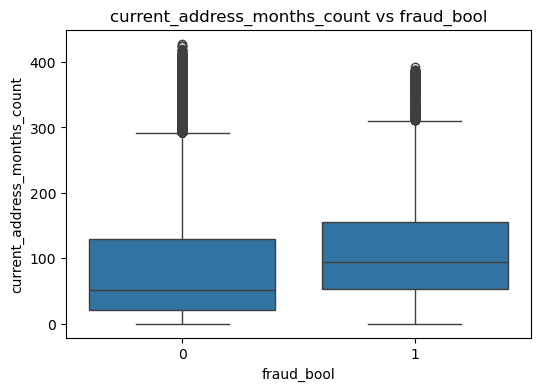

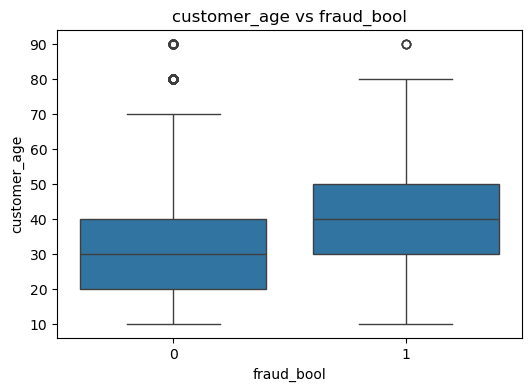

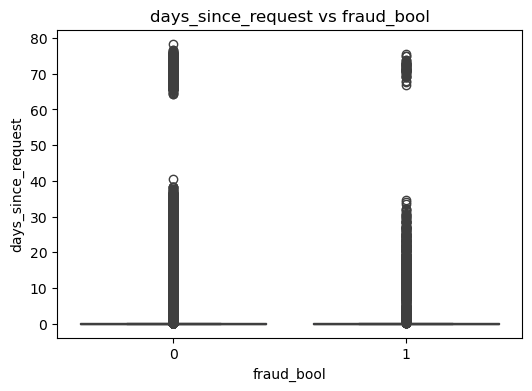

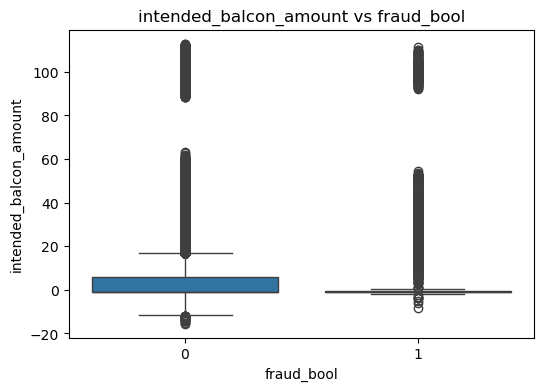

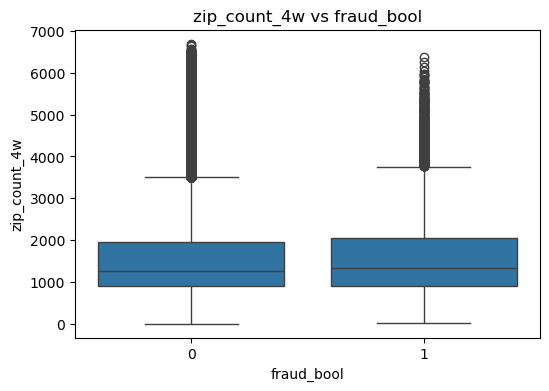

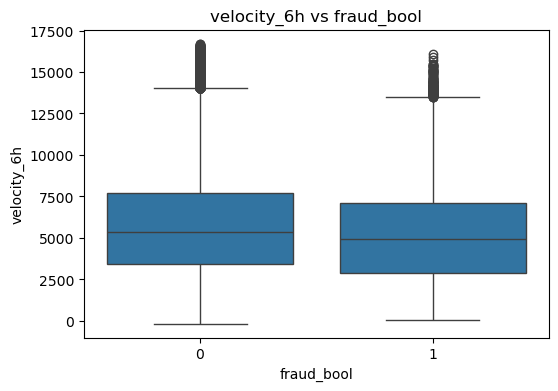

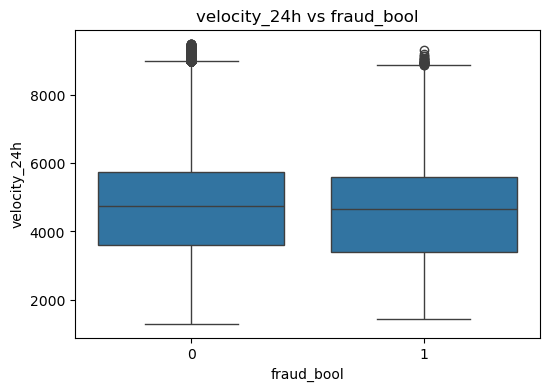

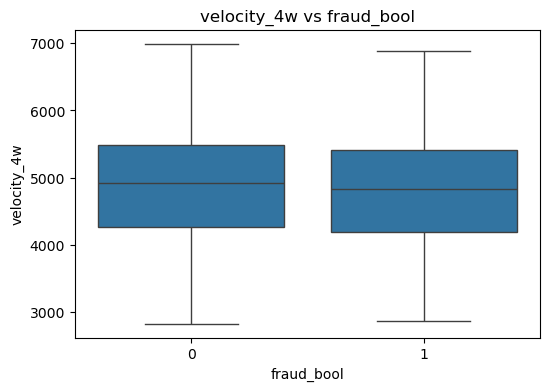

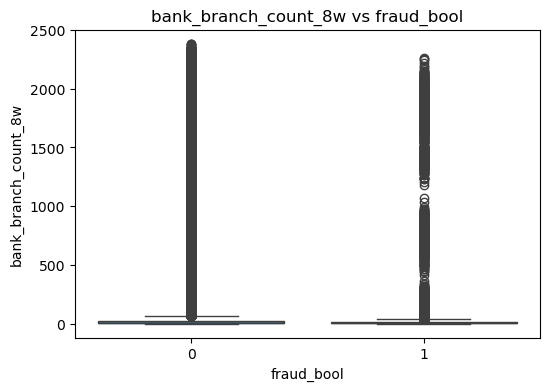

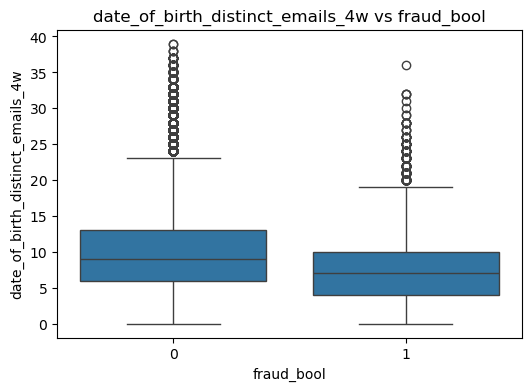

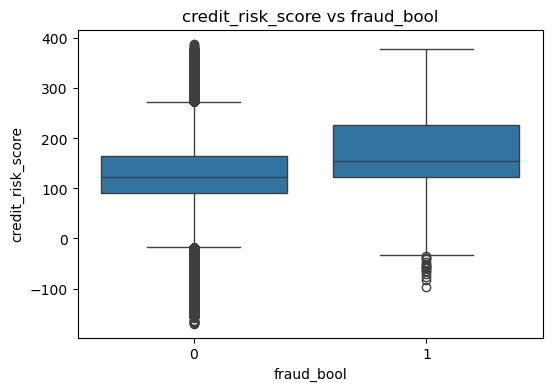

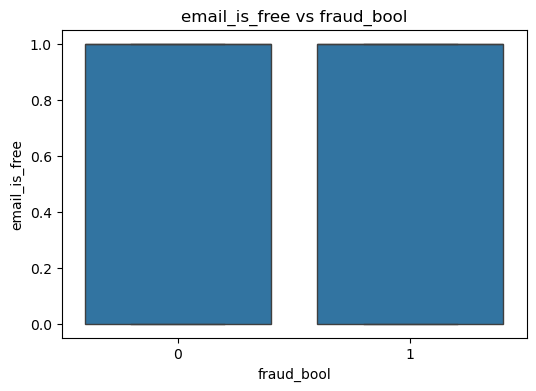

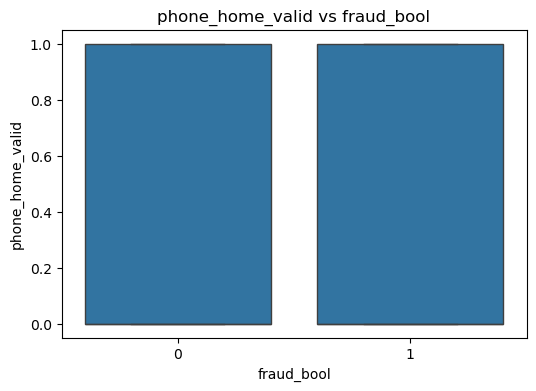

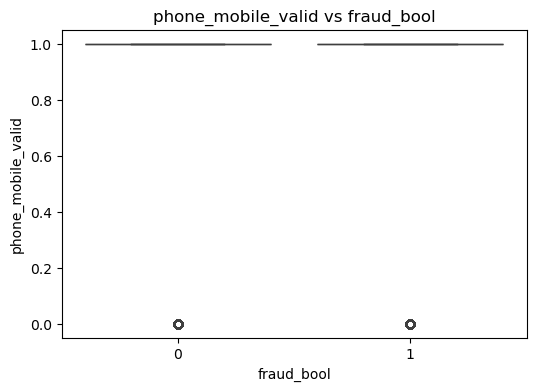

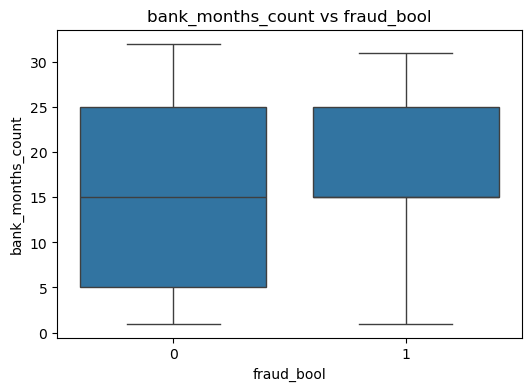

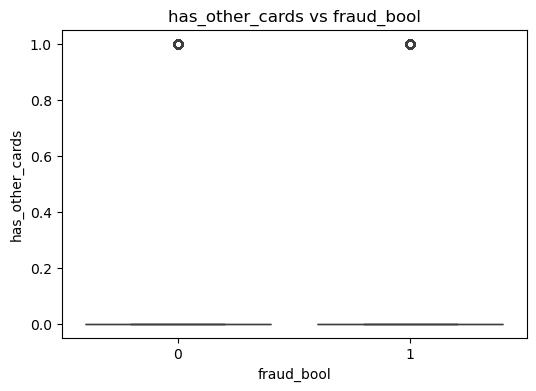

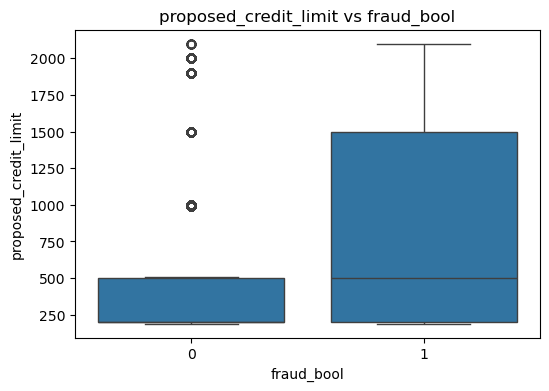

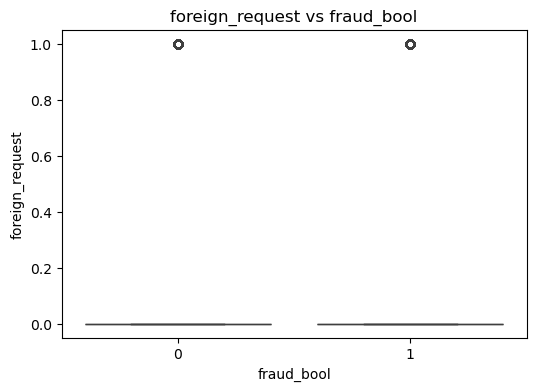

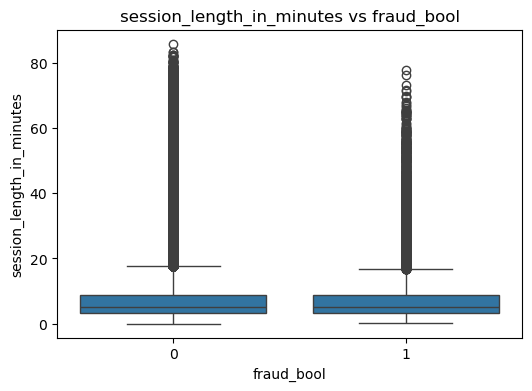

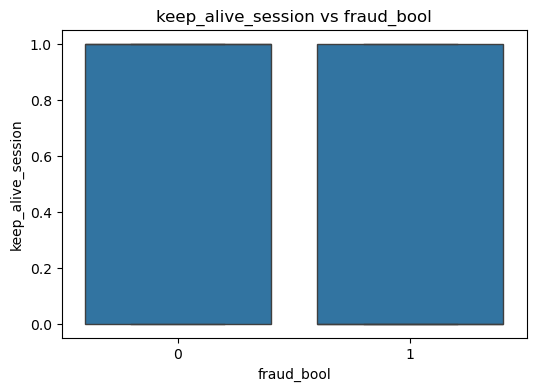

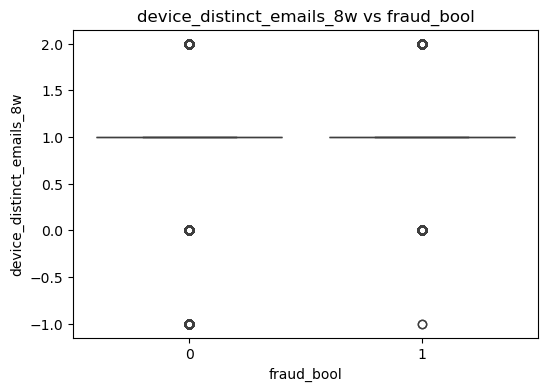

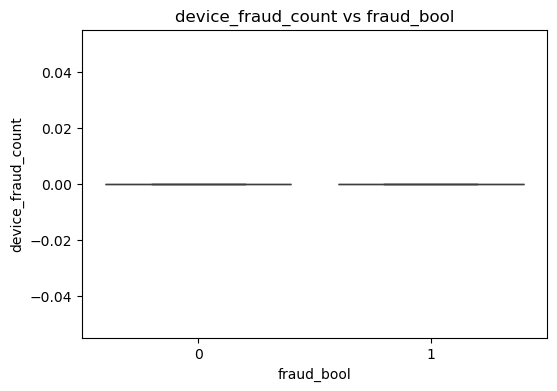

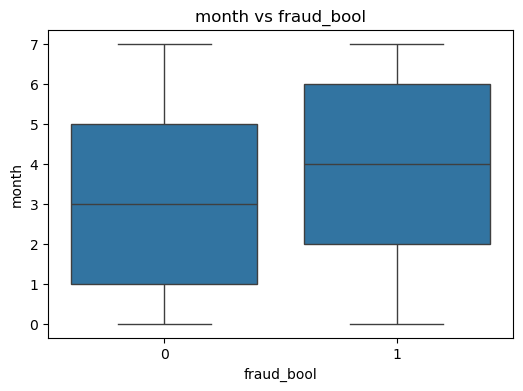

In [ ]:
# Usar boxplots para ver la relación
for col in columnas_numericas:
    if col != 'fraud_bool':
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='fraud_bool', y=col, data=df)
        plt.title(f'{col} vs fraud_bool')
        plt.show()

### 3.3. Categóricas vs Target

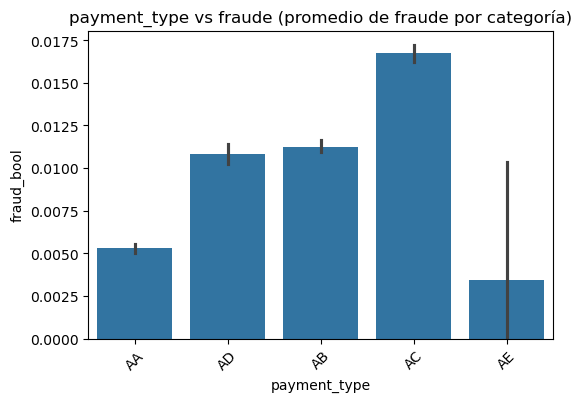

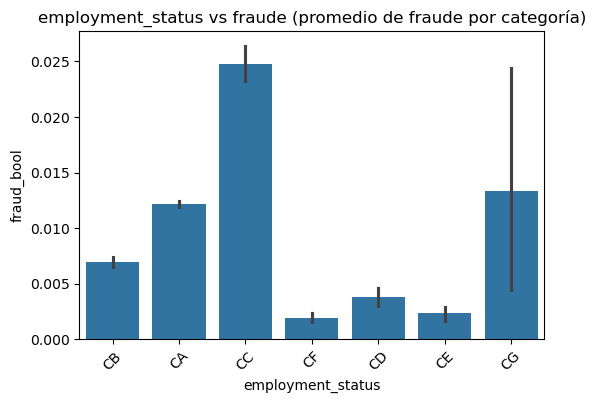

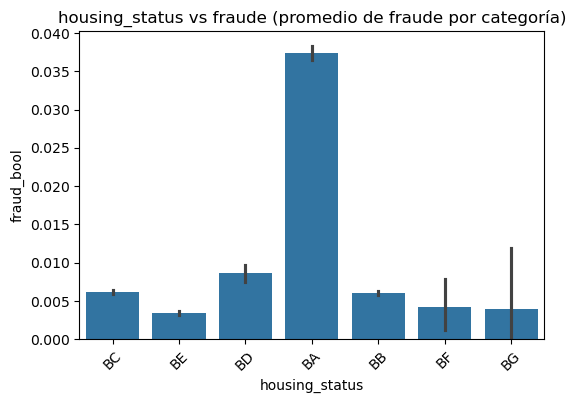

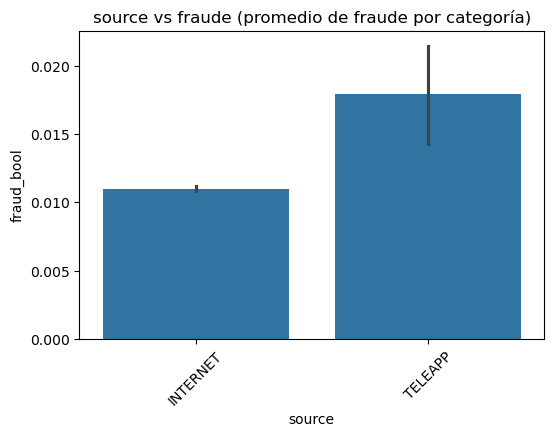

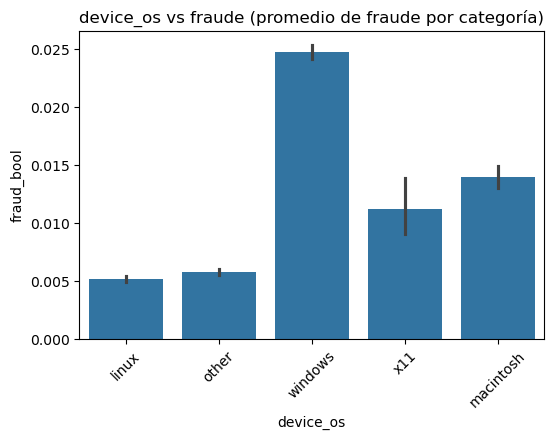

In [ ]:
for col in columnas_categoricas:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=col, y='fraud_bool', data=df)
    plt.title(f'{col} vs fraude (promedio de fraude por categoría)')
    plt.xticks(rotation=45)
    plt.show()

In [129]:
# Guarda DF con resultado final en .csv 
# Lista final de variables seleccionadas
variables_finales = [
    'income',
    'name_email_similarity',
    'customer_age',
    'velocity_6h',
    'velocity_24h',
    'velocity_4w',
    'credit_risk_score',
    'proposed_credit_limit',
    'payment_type',
    'employment_status',
    'housing_status',
    'source',
    'device_os',
    'fraud_bool'  # variable objetivo
]

# Crear nuevo DataFrame
df_final = df[variables_finales]

# Guardar en CSV
df_final.to_csv("data/datos_limpios_seleccionados.csv", index=False)

## 4. PCA

Realiza un PCA y quédate con el número óptimo de componentes. Guarda un nuevo csv que sea un DataFrame con esas N componentes principales en lugar de las columnas originale

### Respuesta:

Se aplicó un PCA sobre las variables numéricas seleccionadas para reducir la dimensionalidad y simplificar el modelo.

Pasos realizados:
- Se estandarizaron los datos numéricos con `StandardScaler`.
- Se aplicó PCA y se evaluó la varianza explicada acumulada.
- Se observó que las primeras 5 componentes explicaban más del 80% de la varianza total, por lo tanto se seleccionaron.
- Se generó un nuevo DataFrame con las 5 componentes principales más la variable `fraud_bool`.

Fue guardado en un archivo `.csv` para ser utilizado en análisis posteriores o modelos de machine learning.


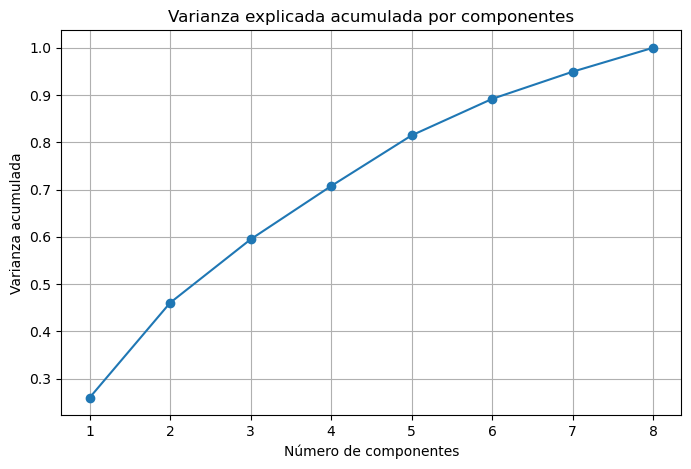

In [ ]:
# Guarda DF con columnas de las componentes importantes del PCA en .csv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Seleccionar solo las columnas numéricas para el PCA (sin la variable objetivo)
columnas_numericas = [
    'income',
    'name_email_similarity',
    'customer_age',
    'velocity_6h',
    'velocity_24h',
    'velocity_4w',
    'credit_risk_score',
    'proposed_credit_limit'
]

# Escalar los datos
escalador = StandardScaler()
datos_escalados = escalador.fit_transform(df[columnas_numericas])

# Aplicar PCA sin limitar el número de componentes
pca = PCA()
componentes = pca.fit_transform(datos_escalados)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Varianza explicada acumulada por componentes")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.show()

In [ ]:
# Seleccionar variables numéricas
columnas_numericas = [
    'income',
    'name_email_similarity',
    'customer_age',
    'velocity_6h',
    'velocity_24h',
    'velocity_4w',
    'credit_risk_score',
    'proposed_credit_limit'
]

# Escalar los datos
escalador = StandardScaler()
datos_escalados = escalador.fit_transform(df[columnas_numericas])

# Aplicar PCA con 5 componentes
pca = PCA(n_components=5)
componentes_pca = pca.fit_transform(datos_escalados)

# Crear DataFrame
df_pca = pd.DataFrame(componentes_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Añadir la variable objetivo
df_pca['fraud_bool'] = df['fraud_bool'].values

# Guardar en CSV
df_pca.to_csv("datos_pca.csv", index=False)